In [2]:
!pip install opencv-python-headless


   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
    --------------------------------------- 0.5/38.9 MB 2.8 MB/s eta 0:00:14
   - -------------------------------------- 1.3/38.9 MB 3.0 MB/s eta 0:00:13
   - -------------------------------------- 1.8/38.9 MB 3.4 MB/s eta 0:00:12
   -- ------------------------------------- 2.9/38.9 MB 3.6 MB/s eta 0:00:11
   --- ------------------------------------ 3.4/38.9 MB 3.5 MB/s eta 0:00:11
   ---- ----------------------------------- 4.2/38.9 MB 3.3 MB/s eta 0:00:11
   ----- ---------------------------------- 5.5/38.9 MB 3.5 MB/s eta 0:00:10
   ------ --------------------------------- 6.3/38.9 MB 3.6 MB/s eta 0:00:10
   ------- -------------------------------- 6.8/38.9 MB 3.5 MB/s eta 0:00:10
   ------- ----------------

In [4]:
!pip install opencv-python


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import torch
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [2]:
data_dir="../data/dr_dataset"

In [3]:
label_map={
    "No_DR":0,
    "Mild":1,
    "Moderate":2,
    "Severe":3,
    "Proliferate DR":4
}

In [4]:
records=[]
print("Looking inside:", data_dir)
print("Folders found:", os.listdir(data_dir))

for folder, label in label_map.items():
    folder_path=os.path.join(data_dir,folder)
    if not os.path.isdir(folder_path):
        continue
    for img_name in os.listdir(folder_path):
        if img_name.lower().endswith(('.jpg','.jpeg','.png')):
            records.append({
                'image_name':img_name,
                'label':label,
                'severity':folder,
                'image_path':os.path.join(folder_path,img_name)
            })
df=pd.DataFrame(records)
if len(df) == 0:
    print(" No images found! Check your data_dir path or image extensions.")
else:
    print(f" Found {len(df)} images total.")
    df.to_csv("../data/image_labels.csv", index=False)
    print(" image_labels.csv saved to ../data/")
    print(df.head())


Looking inside: ../data/dr_dataset
Folders found: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
 Found 2465 images total.
 image_labels.csv saved to ../data/
         image_name  label severity                                 image_path
0  002c21358ce6.png      0    No_DR  ../data/dr_dataset\No_DR\002c21358ce6.png
1  00cc2b75cddd.png      0    No_DR  ../data/dr_dataset\No_DR\00cc2b75cddd.png
2  00f6c1be5a33.png      0    No_DR  ../data/dr_dataset\No_DR\00f6c1be5a33.png
3  0125fbd2e791.png      0    No_DR  ../data/dr_dataset\No_DR\0125fbd2e791.png
4  0182152c50de.png      0    No_DR  ../data/dr_dataset\No_DR\0182152c50de.png


In [5]:
clinical_data=pd.read_csv("../data/image_labels.csv")

In [6]:
np.random.seed(42)

In [7]:
df['age']=np.random.normal(55,12, len(df)).clip(18,90).round(1)
df['sex']=np.random.choice(['M','F'],size=len(df),p=[0.52,0.48])
df['duration']=np.random.gamma(shape=2.0,scale=4.0,size=len(df)).clip(0,40).round(1)
df['hba1c'] = np.random.normal(6.5 + df['label']*0.6, 0.9, size=len(df)).clip(4.0, 15.0).round(2)
df['sbp'] = np.random.normal(122 + df['label']*4.5, 12, size=len(df)).clip(90, 220).round(0)
df['dbp'] = np.random.normal(78 + df['label']*1.8, 8, size=len(df)).clip(50, 130).round(0)
df['bmi'] = np.random.normal(26 + df['label']*0.7, 4.0, size=len(df)).clip(15, 50).round(1)
df['smoking'] = np.random.choice(['Yes','No'], size=len(df), p=[0.20,0.80])
df['ldl'] = np.random.normal(110 + df['label']*5.0, 20, size=len(df)).clip(40, 250).round(0)

In [8]:
dur_z = (df['duration'] - df['duration'].mean()) / (df['duration'].std()+1e-9)
df['hba1c'] = (df['hba1c'] + 0.25 * dur_z).clip(4.0, 15.0).round(2)

age_z = (df['age'] - df['age'].mean()) / (df['age'].std()+1e-9)
df['sbp'] = (df['sbp'] + 3.0 * age_z).clip(90, 220).round(0)

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(df[['hba1c','duration','sbp','age','bmi']])

In [10]:
coef = np.array([0.95, 0.55, 0.20, 0.10, 0.05])   # HbA1c strongest
intercept = -2.2                                   # baseline log-odds
lin = intercept + (X * coef).sum(axis=1)
df['future_dr_risk'] = 1 / (1 + np.exp(-lin))
df['future_dr_label'] = (np.random.rand(len(df)) < df['future_dr_risk']).astype(int)

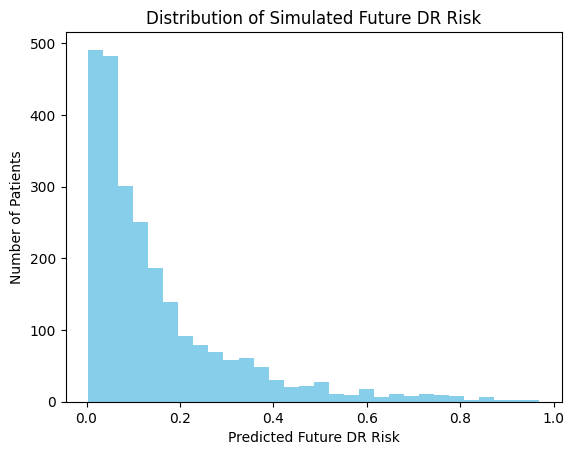

In [11]:
plt.hist(df['future_dr_risk'], bins=30, color='skyblue')
plt.xlabel("Predicted Future DR Risk")
plt.ylabel("Number of Patients")
plt.title("Distribution of Simulated Future DR Risk")
plt.show()

In [12]:
cols = ['image_name','image_path','label','severity',
        'age','sex','duration','hba1c','sbp','dbp','bmi','ldl','smoking',
        'future_dr_risk','future_dr_label']
df[cols].to_csv("../data/multimodal_evidence_based.csv", index=False)

print(" Saved evidence-based synthetic dataset at data/multimodal_evidence_based.csv")
print(df[cols].head())

 Saved evidence-based synthetic dataset at data/multimodal_evidence_based.csv
         image_name                                 image_path  label  \
0  002c21358ce6.png  ../data/dr_dataset\No_DR\002c21358ce6.png      0   
1  00cc2b75cddd.png  ../data/dr_dataset\No_DR\00cc2b75cddd.png      0   
2  00f6c1be5a33.png  ../data/dr_dataset\No_DR\00f6c1be5a33.png      0   
3  0125fbd2e791.png  ../data/dr_dataset\No_DR\0125fbd2e791.png      0   
4  0182152c50de.png  ../data/dr_dataset\No_DR\0182152c50de.png      0   

  severity   age sex  duration  hba1c    sbp   dbp   bmi    ldl smoking  \
0    No_DR  61.0   F      12.4   7.35  101.0  85.0  26.7  126.0      No   
1    No_DR  53.3   M       7.2   5.09  124.0  77.0  22.4  101.0      No   
2    No_DR  62.8   M       4.5   6.86  121.0  77.0  24.7  132.0      No   
3    No_DR  73.3   F       1.1   6.82  114.0  82.0  24.1   86.0     Yes   
4    No_DR  52.2   F       0.5   5.38  101.0  90.0  25.6  104.0      No   

   future_dr_risk  future_dr_lab

In [13]:

df[df['future_dr_label']==1].count()

image_name         349
label              349
severity           349
image_path         349
age                349
sex                349
duration           349
hba1c              349
sbp                349
dbp                349
bmi                349
smoking            349
ldl                349
future_dr_risk     349
future_dr_label    349
dtype: int64

In [14]:
print(df.head())

         image_name  label severity  \
0  002c21358ce6.png      0    No_DR   
1  00cc2b75cddd.png      0    No_DR   
2  00f6c1be5a33.png      0    No_DR   
3  0125fbd2e791.png      0    No_DR   
4  0182152c50de.png      0    No_DR   

                                  image_path   age sex  duration  hba1c  \
0  ../data/dr_dataset\No_DR\002c21358ce6.png  61.0   F      12.4   7.35   
1  ../data/dr_dataset\No_DR\00cc2b75cddd.png  53.3   M       7.2   5.09   
2  ../data/dr_dataset\No_DR\00f6c1be5a33.png  62.8   M       4.5   6.86   
3  ../data/dr_dataset\No_DR\0125fbd2e791.png  73.3   F       1.1   6.82   
4  ../data/dr_dataset\No_DR\0182152c50de.png  52.2   F       0.5   5.38   

     sbp   dbp   bmi smoking    ldl  future_dr_risk  future_dr_label  
0  101.0  85.0  26.7      No  126.0        0.117157                0  
1  124.0  77.0  22.4      No  101.0        0.015180                0  
2  121.0  77.0  24.7      No  132.0        0.051756                0  
3  114.0  82.0  24.1     Yes  

In [15]:
dataset=pd.read_csv("../data/multimodal_evidence_based.csv")
print(dataset.shape)

(2465, 15)


In [16]:
train_df, temp_df = train_test_split(dataset, test_size=0.3, stratify=dataset['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Split sizes → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Split sizes → Train: 1725, Val: 370, Test: 370


In [17]:
dataset.columns

Index(['image_name', 'image_path', 'label', 'severity', 'age', 'sex',
       'duration', 'hba1c', 'sbp', 'dbp', 'bmi', 'ldl', 'smoking',
       'future_dr_risk', 'future_dr_label'],
      dtype='object')

In [18]:
num_cols = ['age','duration','hba1c','sbp','dbp','bmi','ldl']
cat_cols = ['sex','smoking']

In [19]:
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])   # fitting only on train
    val_df[col] = le.transform(val_df[col])           # transforming val
    test_df[col] = le.transform(test_df[col])         # transforming test
    encoders[col] = le

In [20]:
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])   # fittting on train
val_df[num_cols] = scaler.transform(val_df[num_cols])           # transforming val
test_df[num_cols] = scaler.transform(test_df[num_cols])         # transforming test

print("encoders and Scaler fitted on training data only")

encoders and Scaler fitted on training data only


In [21]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [22]:
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [23]:
class DRMultimodalDataset(Dataset):
    def __init__(self, dataframe, transform, num_cols, cat_cols):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        self.num_cols = num_cols
        self.cat_cols = cat_cols

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # --- Loading and preprocessing image ---
        image = Image.open(row.image_path).convert('RGB')
        image = self.transform(image)
        
        # --- Clinical features ---
        numeric_feats = torch.tensor(row[self.num_cols].values.astype(np.float32))
        categorical_feats = torch.tensor(row[self.cat_cols].values.astype(np.float32))
        clinical_input = torch.cat([numeric_feats, categorical_feats])
        
        # --- Labels ---
        current_label = torch.tensor(row.label, dtype=torch.long)
        future_label = torch.tensor(row.future_dr_label, dtype=torch.float32)
        
        return image, clinical_input, current_label, future_label

In [24]:
dataset = DRMultimodalDataset(train_df, train_transform, num_cols, cat_cols)
image, clinical, curr, fut = dataset[11]

print("Image shape:", image.shape)
print("Clinical vector shape:", clinical.shape)
print("Current label:", curr)
print("Future label:", fut)


Image shape: torch.Size([3, 224, 224])
Clinical vector shape: torch.Size([9])
Current label: tensor(2)
Future label: tensor(0.)


In [25]:
#Dataloaderss creation
batch_size = 8

train_dataset = DRMultimodalDataset(train_df, train_transform, num_cols, cat_cols)
val_dataset   = DRMultimodalDataset(val_df, val_test_transform, num_cols, cat_cols)
test_dataset  = DRMultimodalDataset(test_df, val_test_transform, num_cols, cat_cols)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print("dataloaders created")

dataloaders created


In [26]:
# verification
images, clin, curr, fut = next(iter(train_loader))
print(" Image batch shape:", images.shape)
print(" Clinical feature vector shape:", clin.shape)
print(" Current DR labels (0–4):", curr[:5])
print(" Future DR labels (0/1):", fut[:5])


 Image batch shape: torch.Size([8, 3, 224, 224])
 Clinical feature vector shape: torch.Size([8, 9])
 Current DR labels (0–4): tensor([0, 2, 2, 3, 3])
 Future DR labels (0/1): tensor([0., 0., 1., 0., 0.])


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

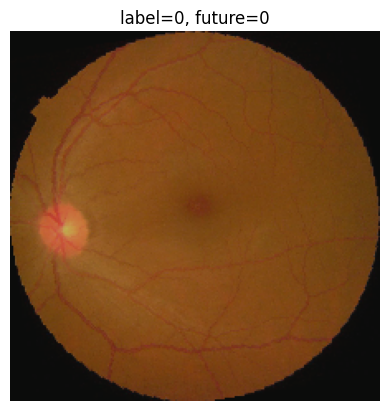

In [27]:
# first image in batch
img = images[0].permute(1,2,0).cpu().numpy()   # (H,W,C)
# undo ImageNet normalization (mean/std)
img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
plt.imshow(np.clip(img, 0, 1))
plt.title(f"label={int(curr[0].item())}, future={int(fut[0].item())}")
plt.axis('off')
